In [1]:
from os import listdir
from collections import defaultdict
from math import comb, ceil

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [10]:
di = "res/"
checksums = {}

for fn in listdir(di):
    acc = 0
    ran = 0
    sel = 0
    with open(di + fn) as inf:
        for l in inf:
            if "access_check" in l:
                acc = int(l.split()[-1])
            elif "rank_check" in l:
                ran = int(l.split()[-1])
            elif "select_check" in l:
                sel = int(l.split()[-1])
    ds = fn.split('_')[-1]
    if ds not in checksums:
        checksums[ds] = [(fn, acc, ran, sel)]
    else:
        checksums[ds].append((fn, acc, ran, sel))

for ds, tups in checksums.items():
    print("======", ds, "=======")
    acc = defaultdict(int)
    ran = defaultdict(int)
    sel = defaultdict(int)
    for t in tups:
        acc[t[1]] += 1
        ran[t[2]] += 1
        if "HYB" not in t[0]:
            sel[t[3]] += 1
    acc_c = sorted(acc.items(), key=lambda x: -x[1])[0][0]
    ran_c = sorted(ran.items(), key=lambda x: -x[1])[0][0]
    sel_c = sorted(sel.items(), key=lambda x: -x[1])[0][0]
    print(acc_c, ran_c, sel_c)
    for t in tups:
        if t[1] != acc_c:
            print(t)
            continue
        if t[2] != ran_c:
            print(t)
            continue
        if "HYB" not in t[0] and t[3] != sel_c:
            print(t)

====== rnd-50.16MB.txt =======
4993939 335600574756625 671349745601225
('HYBRRR_256_32_rnd-50.16MB.txt', 4993570, 335600576641746, 335600576641746)
====== WT-DNA-1GB.txt =======
5828270 22782127594449568 43290239141063738
('HYBRRR_256_32_WT-DNA-1GB.txt', 5826645, 22782127590998922, 22782127590998922)
====== WT-WEB-1GB.txt =======
5288645 23338635564356618 42481085257560706
('HYBRRR_256_32_WT-WEB-1GB.txt', 5288026, 23338635551616740, 23338635551616740)


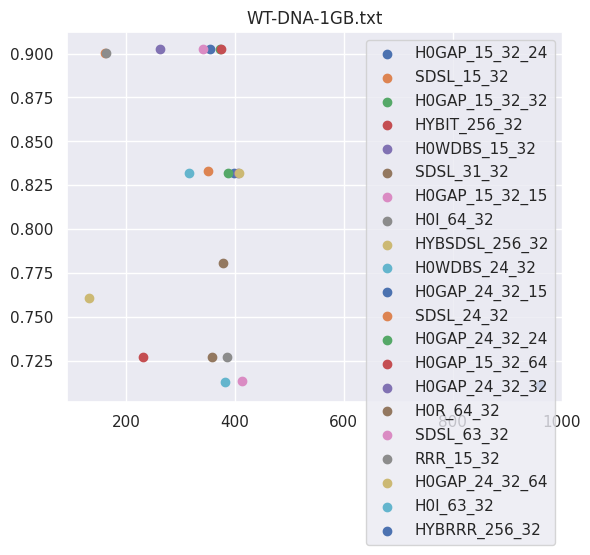

In [67]:
di = "res/"
results = defaultdict(list)

for fn in listdir(di):
    space = 0
    acc = 0
    ran = 0
    sel = 0
    with open(di + fn) as inf:
        for l in inf:
            if "access_time" in l:
                acc = float(l.split()[-1])
            elif "plain_size" in l:
                space = float(l.split()[-1])
            elif "rank_time" in l:
                ran = float(l.split()[-1])
            elif "select_time" in l:
                sel = float(l.split()[-1])
            elif "rrr_size" in l:
                space = float(l.split()[-1]) / space
    ds = fn.split('_')[-1]
    run = "_".join(fn.split('_')[:-1])
    results[ds].append((run, acc, ran, sel, space))

for ds, tups in results.items():
    for t in tups:
        plt.scatter([t[1]], [t[4]])
    plt.title(ds)
    plt.legend([t[0] for t in tups])
    break
plt.show()


In [60]:
for ds, tups in results.items():
    for t in tups:
        print(t)
    break

('H0GAP_15_32_24', 354.26, 387.634, 1418.6)
('SDSL_15_32', 160.796, 254.695, 1143.73)
('H0GAP_15_32_32', 372.679, 440.411, 1457.69)
('HYBIT_256_32', 231.717, 248.407, 252.233)
('H0WDBS_15_32', 262.865, 297.758, 1259.69)
('SDSL_31_32', 378.102, 406.369, 1292.73)
('H0GAP_15_32_15', 340.932, 403.524, 1417.92)
('H0I_64_32', 385.894, 429.187, 1307.25)
('HYBSDSL_256_32', 132.41, 167.801, 172.109)
('H0WDBS_24_32', 316.424, 331.601, 1287.92)
('H0GAP_24_32_15', 397.512, 446.542, 1435.16)
('SDSL_24_32', 349.688, 404.41, 1314.54)
('H0GAP_24_32_24', 387.773, 429.309, 1450.44)
('H0GAP_15_32_64', 374.423, 463.336, 1496.04)
('H0GAP_24_32_32', 406.536, 480.875, 1484.79)
('H0R_64_32', 357.6, 411.796, 1319.12)
('SDSL_63_32', 413.006, 468.522, 1356.02)
('RRR_15_32', 163.47, 262.518, 1182.3)
('H0GAP_24_32_64', 407.047, 491.906, 1510.3)
('H0I_63_32', 381.342, 405.562, 1283.98)
('HYBRRR_256_32', 960.751, 991.648, 995.474)


In [39]:
help(sorted)

Help on built-in function sorted in module builtins:

sorted(iterable, /, *, key=None, reverse=False)
    Return a new list containing all items from the iterable in ascending order.
    
    A custom key function can be supplied to customize the sort order, and the
    reverse flag can be set to request the result in descending order.



In [31]:
tot = 0
for i in range(13):
    tot += ceil(comb(24, i) / 24)
print(tot * 24 / (8 * 1024**2))

1.1611948013305664
